<a href="https://colab.research.google.com/github/Prasad-Khedkar/Topic_Modelling_on_News_Articles/blob/main/Topic_Modelling_on_News_Articles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pyLDAvis

In [2]:
import pandas as pd                                                              ## To frame the data
import os                                                                        ## For listing files in given directory
import matplotlib.pyplot as plt                                                  ## For visualization
import seaborn as sns                                                            ## For visualization

from bs4 import BeautifulSoup                                                    ## Python library used to scrape data from webpages
import re                                                                        ## Module which provides regular expression matching operations
import string                                                                    ## For string manipulation
import nltk                                                                      ## Popular library to pre-process the text in NLP
from nltk.stem import WordNetLemmatizer                                          ## A Lemmatizer  
from nltk.corpus import stopwords                                                ## Stopwords package from nltk
from wordcloud import WordCloud                                                  ## Create interactive wordclouds

from sklearn.decomposition import TruncatedSVD                                   ## For LSA/LSI
from sklearn.decomposition import NMF                                            ## Non-matrix factorization algorithm
from sklearn.decomposition import LatentDirichletAllocation as LDA               ## Latent Dirichlet Allocation algorithm

import pyLDAvis                                                                  ## To visualize LDA topic modelling
import pyLDAvis.sklearn                                                          ## pyLDA with sklearn processing
pyLDAvis.enable_notebook()                                                       ## Enabing notebook for pyLDAvis visualizations

from sklearn.feature_extraction.text import CountVectorizer                      ## count-vectorizer to convert text data into vector form

import warnings                                                                  ## Ignore warnings
warnings. simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) 

/usr/local/lib/python3.8/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Iterable


In [ ]:
 nltk.download('wordnet')                                                        ## Downloading important packages
 nltk.download('omw-1.4')
 nltk.download('stopwords')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
path = '/content/drive/My Drive/Projects/Topic_Modelling_on_News_Articles/Data/bbc/'

In [6]:
news = []                                                                        ## Empty list for storing actual news in text       
topics = []                                                                      ## Empty list for new theme

In [7]:
Themes = ['business','entertainment','politics','sport','tech']  ## News themes 

In [8]:
for x in Themes:                                                                 ## For every item in Themes
    all_txt_files=sorted(os.listdir(path+x))                                     ## List all files present in given directory in sorted order
    for files in all_txt_files:                                                  ## For every item in txt_files
        txt_path=path + x + '/' + files                                          ## specifying exact path of every text news file
        with open(txt_path,'rb') as f:                                           ## open a text file
            text=f.read()                                                        ## read text file
        news.append(text)                                                        ## append text file which is our news, to empty news list
        topics.append(x)                                                         ## append the topic of news file to empty topics list

In [9]:
df_raw = pd.DataFrame()                                                          ## creating empty dataframe

In [10]:
df_raw['News_text'] = news                                                       ## adding News column 
df_raw['News_Theme'] = topics                                                    ## adding News_theme column

In [11]:
df_raw.head()

,News_text,News_Theme
0,b'Ad sales boost Time Warner profit\n\nQuarter...,business
1,b'Dollar gains on Greenspan speech\n\nThe doll...,business
2,b'Yukos unit buyer faces loan claim\n\nThe own...,business
3,b'High fuel prices hit BA\'s profits\n\nBritis...,business
4,"b""Pernod takeover talk lifts Domecq\n\nShares ...",business


In [12]:
df_raw.tail()

,News_text,News_Theme
2220,b'BT program to beat dialler scams\n\nBT is in...,tech
2221,b'Spam e-mails tempt net shoppers\n\nComputer ...,tech
2222,b'Be careful how you code\n\nA new European di...,tech
2223,b'US cyber security chief resigns\n\nThe man m...,tech
2224,b'Losing yourself in online gaming\n\nOnline r...,tech


In [13]:
df_raw.shape                                                                     ## Shape of raw data with total 2225 rows and 2 columns

(2225, 2)

## Data Cleaning

In [14]:
df = df_raw.copy()                                                               ## First creating a deep copy

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   News_text   2225 non-null   object
 1   News_Theme  2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [16]:
df.isnull().sum()

News_text     0
News_Theme    0
dtype: int64

### *Insight* : No null values present 

In [17]:
df.drop_duplicates(keep = 'first',inplace = True)                                ## Dropping duplicate values/rows

In [18]:
df.shape                                                                         ## shape changed 

(2127, 2)

In [19]:
2225-2127                                                                        ## No. of duplicate rows present

98

### *Insight* : Total 98 duplicate rows found and removed

In [20]:
a = df['News_Theme'].value_counts()
a

sport            505
business         503
politics         403
entertainment    369
tech             347
Name: News_Theme, dtype: int64

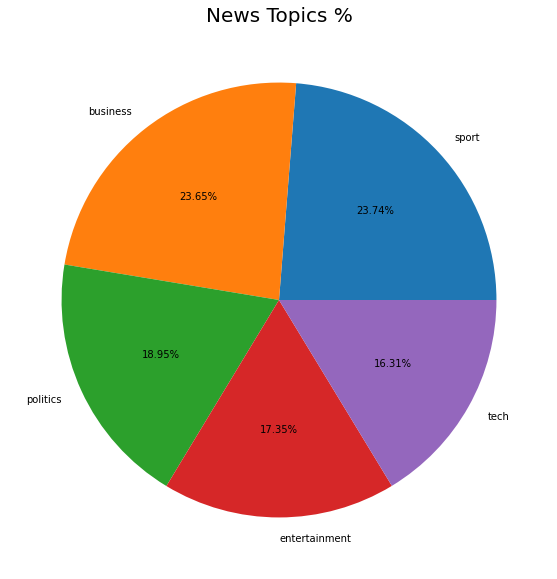

In [21]:
plt.figure(figsize = (10,10))
plt.pie(a, autopct = '%0.2f%%' , labels = a.index)
plt.title('News Topics %', size = 20)
plt.show()

## NLP Text Pre-processing

In [22]:
df['News_text'][0]

b'Ad sales boost Time Warner profit\n\nQuarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (\xc2\xa3600m) for the three months to December, from $639m year-earlier.\n\nThe firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.\n\nTime Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL\'s underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will tr

In [23]:
df['News_text'] = [BeautifulSoup(k).get_text() for k in df['News_text'] ]                   ## Getting data from any html tags if present

In [24]:
df['News_text'] = [re.sub(r'https?://\S+|www\.\S+', '', k1) for k1 in df['News_text']]      ## Removing any urls present

In [25]:
df['News_text'][0]

'Ad sales boost Time Warner profit\n\nQuarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (Â£600m) for the three months to December, from $639m year-earlier.\n\nThe firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.\n\nTime Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL\'s underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will try to si

## Removing non-word characters

In [26]:
df['News_text'] = [re.sub(r"b\'", "", k2) for k2 in df['News_text']]                       ## Replacing 'b\' character with ''

In [27]:
df['News_text'][2]

'Yukos unit buyer faces loan claim\n\nThe owners of embattled Russian oil giant Yukos are to ask the buyer of its former production unit to pay back a $900m (Â£479m) loan.\n\nState-owned Rosneft bought the Yugansk unit for $9.3bn in a sale forced by Russia to part settle a $27.5bn tax claim against Yukos. Yukos\' owner Menatep Group says it will ask Rosneft to repay a loan that Yugansk had secured on its assets. Rosneft already faces a similar $540m repayment demand from foreign banks. Legal experts said Rosneft\'s purchase of Yugansk would include such obligations. "The pledged assets are with Rosneft, so it will have to pay real money to the creditors to avoid seizure of Yugansk assets," said Moscow-based US lawyer Jamie Firestone, who is not connected to the case. Menatep Group\'s managing director Tim Osborne told the Reuters news agency: "If they default, we will fight them where the rule of law exists under the international arbitration clauses of the credit."\n\nRosneft official

In [28]:
df['News_text'] = [re.sub(r"\\n\\n", " ",k3) for k3 in df['News_text']]                    ## Replacing other non-word characters
df['News_text'] = [re.sub(r"\\\'s", " ",k4) for k4 in df['News_text']] 
df['News_text'] = [re.sub(r"\\\'", " ", k5) for k5 in df['News_text']]
df['News_text'] = [re.sub(r"\\n\'", " ", k6) for k6 in df['News_text']]
df['News_text'] = [re.sub(r"\n\n", " ", k7) for k7 in df['News_text']]
df['News_text'] = [re.sub(r'\\xc2\\xa3','\xA3', k8) for k8 in df['News_text']]             ## "\xA3" is unicode for symbol pound(£)   
df['News_text'] = [re.sub(r"\'s",'', k9) for k9 in df['News_text']] 
df['News_text'] = [re.sub(r'\\n"','', k10) for k10 in df['News_text']] 
df['News_text'] = [re.sub(r'b"','', k11) for k11 in df['News_text']] 
df['News_text'] = [re.sub(r'\n','', k12) for k12 in df['News_text']]

In [29]:
df_raw['News_text'][5]                                                                ## News before removing characters

b'Japan narrowly escapes recession\n\nJapan\'s economy teetered on the brink of a technical recession in the three months to September, figures show.\n\nRevised figures indicated growth of just 0.1% - and a similar-sized contraction in the previous quarter. On an annual basis, the data suggests annual growth of just 0.2%, suggesting a much more hesitant recovery than had previously been thought. A common technical definition of a recession is two successive quarters of negative growth.\n\nThe government was keen to play down the worrying implications of the data. "I maintain the view that Japan\'s economy remains in a minor adjustment phase in an upward climb, and we will monitor developments carefully," said economy minister Heizo Takenaka. But in the face of the strengthening yen making exports less competitive and indications of weakening economic conditions ahead, observers were less sanguine. "It\'s painting a picture of a recovery... much patchier than previously thought," said P

In [30]:
df['News_text'][5]                                                                    ## After removing non-word characters

'Japan narrowly escapes recession Japan economy teetered on the brink of a technical recession in the three months to September, figures show. Revised figures indicated growth of just 0.1% - and a similar-sized contraction in the previous quarter. On an annual basis, the data suggests annual growth of just 0.2%, suggesting a much more hesitant recovery than had previously been thought. A common technical definition of a recession is two successive quarters of negative growth. The government was keen to play down the worrying implications of the data. "I maintain the view that Japan economy remains in a minor adjustment phase in an upward climb, and we will monitor developments carefully," said economy minister Heizo Takenaka. But in the face of the strengthening yen making exports less competitive and indications of weakening economic conditions ahead, observers were less sanguine. "It painting a picture of a recovery... much patchier than previously thought," said Paul Sheard, economi

## Removing Punctuations

In [31]:
string.punctuation                                                               ## Total Punctuations

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [32]:
def rem_punct(text):                                                             ## Function to remove punctuations
  """This function will remove punctuations."""
  text_no_punct = [char for char in text if char not in '!"#$%&\'()*+,-./:;?@[\\]^_{|}~`£' ]
  text_no_punct = ''.join(text_no_punct)
  return text_no_punct

In [33]:
df['News_text'] = df['News_text'].apply(lambda x: rem_punct(x))

In [34]:
df['News_text'][5]

'Japan narrowly escapes recession Japan economy teetered on the brink of a technical recession in the three months to September figures show Revised figures indicated growth of just 01  and a similarsized contraction in the previous quarter On an annual basis the data suggests annual growth of just 02 suggesting a much more hesitant recovery than had previously been thought A common technical definition of a recession is two successive quarters of negative growth The government was keen to play down the worrying implications of the data I maintain the view that Japan economy remains in a minor adjustment phase in an upward climb and we will monitor developments carefully said economy minister Heizo Takenaka But in the face of the strengthening yen making exports less competitive and indications of weakening economic conditions ahead observers were less sanguine It painting a picture of a recovery much patchier than previously thought said Paul Sheard economist at Lehman Brothers in Tok

## Lowering the case

In [35]:
df['News_text'] = [lc.lower() for lc in df['News_text']]                                   ## Lower the case to give equal importance to words

In [36]:
df['News_text'][5]

'japan narrowly escapes recession japan economy teetered on the brink of a technical recession in the three months to september figures show revised figures indicated growth of just 01  and a similarsized contraction in the previous quarter on an annual basis the data suggests annual growth of just 02 suggesting a much more hesitant recovery than had previously been thought a common technical definition of a recession is two successive quarters of negative growth the government was keen to play down the worrying implications of the data i maintain the view that japan economy remains in a minor adjustment phase in an upward climb and we will monitor developments carefully said economy minister heizo takenaka but in the face of the strengthening yen making exports less competitive and indications of weakening economic conditions ahead observers were less sanguine it painting a picture of a recovery much patchier than previously thought said paul sheard economist at lehman brothers in tok

## Removing Extra space

In [37]:
df['News_text'] = [re.sub(r'  ','', e_sp) for e_sp in df['News_text']]                      ## Removing extra space to save memory

In [38]:
df['News_text'][6]

'jobs growth still slow in the us the us created fewer jobs than expected in january but a fall in jobseekers pushed the unemployment rate to its lowest level in three years according to labor department figures us firms added only 146000 jobs in january the gain in nonfarm payrolls was below market expectations of 190000 new jobs nevertheless it was enough to push down the unemployment rate to 52 its lowest level since september 2001 the job gains mean that president bush can celebratealbeit by a very fine margina net growth in jobs in the us economy in his first term in office he presided over a net fall in jobs up to last november presidential electionthe first president to do so since herbert hoover as a result job creation became a key issue in last year election however when adding december and january figures the administration first term jobs record ended in positive territory the labor department also said it had revised down the jobs gains in december 2004 from 157000 to 1330

## Removing Numbers

In [39]:
df['News_text'] = [re.sub(r'\d+','', d1) for d1 in df['News_text']]              ## This removes any numbers present

In [40]:
df['News_text'][1]

'dollar gains on greenspan speech the dollar has hit its highest level against the euro in almost three months after the federal reserve head said the us trade deficit is set to stabilise and alan greenspan highlighted the us government willingness to curb spending and rising household savings as factors which may help to reduce it in late trading in new york the dollar reached  against the euro from  on thursday market concerns about the deficit has hit the greenback in recent months on friday federal reserve chairman mr greenspan speech in london ahead of the meeting of g finance ministers sent the dollar higher after it had earlier tumbled on the back of worsethanexpected us jobs data i think the chairman taking a much more sanguine view on the current account deficit than he taken for some time said robert sinche head of currency strategy at bank of america in new york he taking a longerterm view laying out a set of conditions under which the current account deficit can improve thi

## Tokenization

In [41]:
def tokenize(text):                                                              ## Defining function to create list of tokens
  """ This function gives list of tokens."""
  tokens = re.split('\W+', text)
  return tokens

In [42]:
df['Tokens'] = df['News_text'].apply(tokenize)

In [43]:
df.head()

,News_text,News_Theme,Tokens
0,ad sales boost time warner profit quarterly pr...,business,"[ad, sales, boost, time, warner, profit, quart..."
1,dollar gains on greenspan speech the dollar ha...,business,"[dollar, gains, on, greenspan, speech, the, do..."
2,yukos unit buyer faces loan claim the owners o...,business,"[yukos, unit, buyer, faces, loan, claim, the, ..."
3,high fuel prices hit ba profits british airway...,business,"[high, fuel, prices, hit, ba, profits, british..."
4,pernod takeover talk lifts domecq shares in uk...,business,"[pernod, takeover, talk, lifts, domecq, shares..."


## Removing Stop words

In [44]:
swds = nltk.corpus.stopwords.words('english') 

In [45]:
df.head()

,News_text,News_Theme,Tokens
0,ad sales boost time warner profit quarterly pr...,business,"[ad, sales, boost, time, warner, profit, quart..."
1,dollar gains on greenspan speech the dollar ha...,business,"[dollar, gains, on, greenspan, speech, the, do..."
2,yukos unit buyer faces loan claim the owners o...,business,"[yukos, unit, buyer, faces, loan, claim, the, ..."
3,high fuel prices hit ba profits british airway...,business,"[high, fuel, prices, hit, ba, profits, british..."
4,pernod takeover talk lifts domecq shares in uk...,business,"[pernod, takeover, talk, lifts, domecq, shares..."


In [46]:
def remove_sw(tokenized_list):                                                   ## Defining function to remove stopwords
  """This function will remove stopwords."""
  text = [word for word in tokenized_list if word not in swds]
  return text

In [47]:
df['Tokens(without stop words)'] = df['Tokens'].apply(remove_sw)                 ## Calling function to new column

In [48]:
df.head()

,News_text,News_Theme,Tokens,Tokens(without stop words)
0,ad sales boost time warner profit quarterly pr...,business,"[ad, sales, boost, time, warner, profit, quart...","[ad, sales, boost, time, warner, profit, quart..."
1,dollar gains on greenspan speech the dollar ha...,business,"[dollar, gains, on, greenspan, speech, the, do...","[dollar, gains, greenspan, speech, dollar, hit..."
2,yukos unit buyer faces loan claim the owners o...,business,"[yukos, unit, buyer, faces, loan, claim, the, ...","[yukos, unit, buyer, faces, loan, claim, owner..."
3,high fuel prices hit ba profits british airway...,business,"[high, fuel, prices, hit, ba, profits, british...","[high, fuel, prices, hit, ba, profits, british..."
4,pernod takeover talk lifts domecq shares in uk...,business,"[pernod, takeover, talk, lifts, domecq, shares...","[pernod, takeover, talk, lifts, domecq, shares..."


In [49]:
df['news_without_stopwords'] = [' '.join(word) for word in df['Tokens(without stop words)']]

In [50]:
df.head()

,News_text,News_Theme,Tokens,Tokens(without stop words),news_without_stopwords
0,ad sales boost time warner profit quarterly pr...,business,"[ad, sales, boost, time, warner, profit, quart...","[ad, sales, boost, time, warner, profit, quart...",ad sales boost time warner profit quarterly pr...
1,dollar gains on greenspan speech the dollar ha...,business,"[dollar, gains, on, greenspan, speech, the, do...","[dollar, gains, greenspan, speech, dollar, hit...",dollar gains greenspan speech dollar hit highe...
2,yukos unit buyer faces loan claim the owners o...,business,"[yukos, unit, buyer, faces, loan, claim, the, ...","[yukos, unit, buyer, faces, loan, claim, owner...",yukos unit buyer faces loan claim owners embat...
3,high fuel prices hit ba profits british airway...,business,"[high, fuel, prices, hit, ba, profits, british...","[high, fuel, prices, hit, ba, profits, british...",high fuel prices hit ba profits british airway...
4,pernod takeover talk lifts domecq shares in uk...,business,"[pernod, takeover, talk, lifts, domecq, shares...","[pernod, takeover, talk, lifts, domecq, shares...",pernod takeover talk lifts domecq shares uk dr...


## Lemmatization

#### Lemmatization is a development of Stemming and describes the process of grouping together the different inflected forms of a word so they can be analyzed as a single item. Lemmatization is similar to Stemming but it brings context to the words. So it links words with similar meanings to one word. Lemmatization algorithms usually also use positional arguments as inputs, such as whether the word is an adjective, noun, or verb.



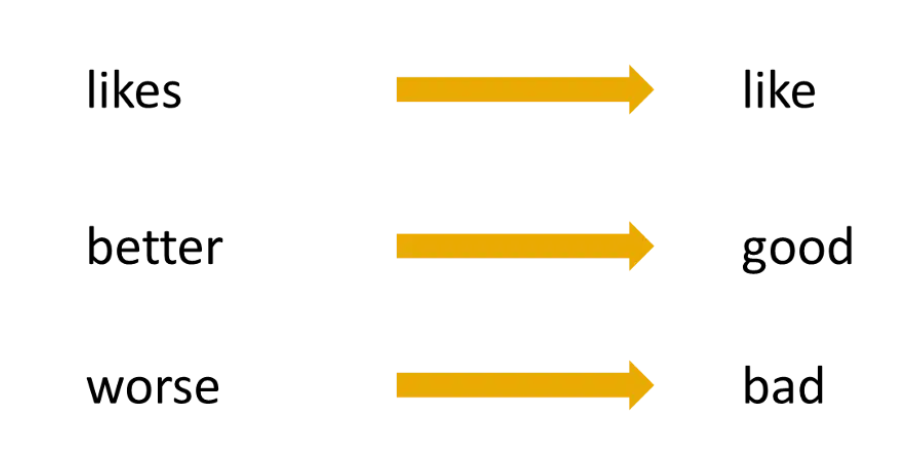
  
  

In [51]:
lmt = WordNetLemmatizer()                                                        ## Creating WordNetLemmatizer() object

In [52]:
def lemmatizing(news):                                                           ## defining a lemmatizer function
  """This function will lemmatize each word in news."""
  text = [lmt.lemmatize(word) for word in news.split()]
  return text

In [53]:
df['lemmatized_tokens(no_sw)'] = df['news_without_stopwords'].apply(lemmatizing)

In [54]:
df.head()

,News_text,News_Theme,Tokens,Tokens(without stop words),news_without_stopwords,lemmatized_tokens(no_sw)
0,ad sales boost time warner profit quarterly pr...,business,"[ad, sales, boost, time, warner, profit, quart...","[ad, sales, boost, time, warner, profit, quart...",ad sales boost time warner profit quarterly pr...,"[ad, sale, boost, time, warner, profit, quarte..."
1,dollar gains on greenspan speech the dollar ha...,business,"[dollar, gains, on, greenspan, speech, the, do...","[dollar, gains, greenspan, speech, dollar, hit...",dollar gains greenspan speech dollar hit highe...,"[dollar, gain, greenspan, speech, dollar, hit,..."
2,yukos unit buyer faces loan claim the owners o...,business,"[yukos, unit, buyer, faces, loan, claim, the, ...","[yukos, unit, buyer, faces, loan, claim, owner...",yukos unit buyer faces loan claim owners embat...,"[yukos, unit, buyer, face, loan, claim, owner,..."
3,high fuel prices hit ba profits british airway...,business,"[high, fuel, prices, hit, ba, profits, british...","[high, fuel, prices, hit, ba, profits, british...",high fuel prices hit ba profits british airway...,"[high, fuel, price, hit, ba, profit, british, ..."
4,pernod takeover talk lifts domecq shares in uk...,business,"[pernod, takeover, talk, lifts, domecq, shares...","[pernod, takeover, talk, lifts, domecq, shares...",pernod takeover talk lifts domecq shares uk dr...,"[pernod, takeover, talk, lift, domecq, share, ..."


In [55]:
df['clean_news'] = [' '.join(word) for word in df['lemmatized_tokens(no_sw)']]   ## Final clean news.

In [56]:
df.head()

,News_text,News_Theme,Tokens,Tokens(without stop words),news_without_stopwords,lemmatized_tokens(no_sw),clean_news
0,ad sales boost time warner profit quarterly pr...,business,"[ad, sales, boost, time, warner, profit, quart...","[ad, sales, boost, time, warner, profit, quart...",ad sales boost time warner profit quarterly pr...,"[ad, sale, boost, time, warner, profit, quarte...",ad sale boost time warner profit quarterly pro...
1,dollar gains on greenspan speech the dollar ha...,business,"[dollar, gains, on, greenspan, speech, the, do...","[dollar, gains, greenspan, speech, dollar, hit...",dollar gains greenspan speech dollar hit highe...,"[dollar, gain, greenspan, speech, dollar, hit,...",dollar gain greenspan speech dollar hit highes...
2,yukos unit buyer faces loan claim the owners o...,business,"[yukos, unit, buyer, faces, loan, claim, the, ...","[yukos, unit, buyer, faces, loan, claim, owner...",yukos unit buyer faces loan claim owners embat...,"[yukos, unit, buyer, face, loan, claim, owner,...",yukos unit buyer face loan claim owner embattl...
3,high fuel prices hit ba profits british airway...,business,"[high, fuel, prices, hit, ba, profits, british...","[high, fuel, prices, hit, ba, profits, british...",high fuel prices hit ba profits british airway...,"[high, fuel, price, hit, ba, profit, british, ...",high fuel price hit ba profit british airway b...
4,pernod takeover talk lifts domecq shares in uk...,business,"[pernod, takeover, talk, lifts, domecq, shares...","[pernod, takeover, talk, lifts, domecq, shares...",pernod takeover talk lifts domecq shares uk dr...,"[pernod, takeover, talk, lift, domecq, share, ...",pernod takeover talk lift domecq share uk drin...


In [57]:
df['clean_news'][1]

'dollar gain greenspan speech dollar hit highest level euro almost three month federal reserve head said u trade deficit set stabilise alan greenspan highlighted u government willingness curb spending rising household saving factor may help reduce late trading new york dollar reached euro thursday market concern deficit hit greenback recent month friday federal reserve chairman mr greenspan speech london ahead meeting g finance minister sent dollar higher earlier tumbled back worsethanexpected u job data think chairman taking much sanguine view current account deficit taken time said robert sinche head currency strategy bank america new york taking longerterm view laying set condition current account deficit improve year next worry deficit concern china however remain china currency remains pegged dollar u currency sharp fall recent month therefore made chinese export price highly competitive call shift beijing policy fallen deaf ear despite recent comment major chinese newspaper time 

## Frequent Words

In [58]:
all_words = ''.join(df['clean_news']).split()                                    ## Storing all words in list
all_words

['ad',
 'sale',
 'boost',
 'time',
 'warner',
 'profit',
 'quarterly',
 'profit',
 'u',
 'medium',
 'giant',
 'timewarner',
 'jumped',
 'bn',
 'âm',
 'three',
 'month',
 'december',
 'yearearlier',
 'firm',
 'one',
 'biggest',
 'investor',
 'google',
 'benefited',
 'sale',
 'highspeed',
 'internet',
 'connection',
 'higher',
 'advert',
 'sale',
 'timewarner',
 'said',
 'fourth',
 'quarter',
 'sale',
 'rose',
 'bn',
 'bn',
 'profit',
 'buoyed',
 'oneoff',
 'gain',
 'offset',
 'profit',
 'dip',
 'warner',
 'bros',
 'le',
 'user',
 'aol',
 'time',
 'warner',
 'said',
 'friday',
 'owns',
 'searchengine',
 'google',
 'internet',
 'business',
 'aol',
 'mixed',
 'fortune',
 'lost',
 'subscriber',
 'fourth',
 'quarter',
 'profit',
 'lower',
 'preceding',
 'three',
 'quarter',
 'however',
 'company',
 'said',
 'aol',
 'underlying',
 'profit',
 'exceptional',
 'item',
 'rose',
 'back',
 'stronger',
 'internet',
 'advertising',
 'revenue',
 'hope',
 'increase',
 'subscriber',
 'offering',
 'onlin

In [59]:
len(all_words)                                                                   ## Total words in all documents

457258

In [60]:
all_words = pd.Series(all_words)                                                 ## converting to series for further operations

In [61]:
all_words.value_counts()[:20]

said          6820
mr            2897
year          2654
would         2452
also          2035
people        1871
new           1854
u             1806
one           1699
could         1433
game          1398
time          1374
last          1319
first         1222
say           1201
government    1154
world         1148
two           1131
company       1053
film          1013
dtype: int64

In [62]:
useless_words = ['said','say', 'mr','would','make','also','year','take','could','use','time','go','u','two','told']

In [63]:
df['clean_news'][0]

'ad sale boost time warner profit quarterly profit u medium giant timewarner jumped bn âm three month december yearearlier firm one biggest investor google benefited sale highspeed internet connection higher advert sale timewarner said fourth quarter sale rose bn bn profit buoyed oneoff gain offset profit dip warner bros le user aol time warner said friday owns searchengine google internet business aol mixed fortune lost subscriber fourth quarter profit lower preceding three quarter however company said aol underlying profit exceptional item rose back stronger internet advertising revenue hope increase subscriber offering online service free timewarner internet customer try sign aol existing customer highspeed broadband timewarner also restate result following probe u security exchange commission sec close concluding time warner fourth quarter profit slightly better analyst expectation film division saw profit slump helped boxoffice flop alexander catwoman sharp contrast yearearlier th

In [64]:
len(df['clean_news'][0].split())                                                 ## Words in first news before removing useless words 

240

In [65]:
def remove_words(klp):                                                           ## Defining function to remove useless words
    """ Function to remove useless_words. """
    return ' '.join(x for x in klp.split() if x not in useless_words)

In [66]:
df['clean_news'] = df['clean_news'].apply(remove_words)                          ## Applying function

In [67]:
df['clean_news'][0]

'ad sale boost warner profit quarterly profit medium giant timewarner jumped bn âm three month december yearearlier firm one biggest investor google benefited sale highspeed internet connection higher advert sale timewarner fourth quarter sale rose bn bn profit buoyed oneoff gain offset profit dip warner bros le user aol warner friday owns searchengine google internet business aol mixed fortune lost subscriber fourth quarter profit lower preceding three quarter however company aol underlying profit exceptional item rose back stronger internet advertising revenue hope increase subscriber offering online service free timewarner internet customer try sign aol existing customer highspeed broadband timewarner restate result following probe security exchange commission sec close concluding warner fourth quarter profit slightly better analyst expectation film division saw profit slump helped boxoffice flop alexander catwoman sharp contrast yearearlier third final film lord ring trilogy booste

In [68]:
len(df['clean_news'][0].split())                                                 ## Total words in first news after removing useless words

227

In [69]:
new_words = ''.join(df['clean_news']).split()                                    ## splitting new words after removing useless words

In [70]:
new_words = pd.Series(new_words)                                                 ## Again converting to series after useless words are removed

In [71]:
new_list = new_words.value_counts()                                              ## Value counts of each word
new_list

people           1871
new              1854
one              1699
game             1398
last             1311
                 ... 
juliet              1
commemorate         1
scorsesekeanu       1
idaho               1
dayslol             1
Length: 31956, dtype: int64

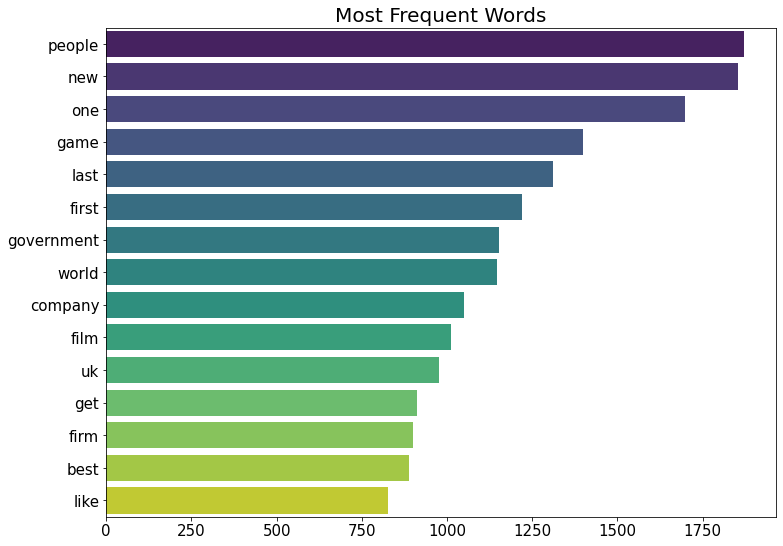

In [72]:
plt.figure(figsize = (12,9))
sns.barplot(x = new_list[:15], y = new_list.index[:15] , palette = 'viridis')     ## Horizontal Barplot of word counts
plt.title('Most Frequent Words' , size = 20)
plt.yticks(size = 15)
plt.xticks(size = 15)
plt.show()

In [73]:
dall_news = ''.join(df['clean_news'])                                            ## Joining for wordcloud operation
type(dall_news)

str

## WordCloud

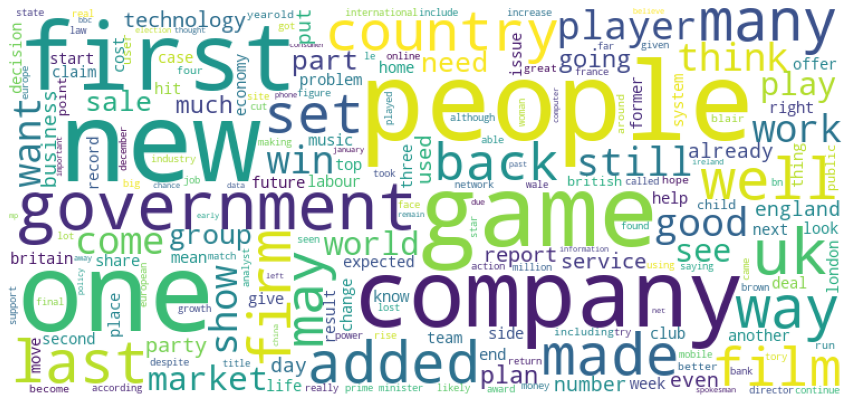

In [74]:
plt.figure(figsize = (15,15))
word_cloud = WordCloud(width= 750 , height= 350 ,background_color ='white',  max_font_size=100).generate(dall_news)
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

## **CountVectorizer**

### Count vectorizer converts textual data to machine readable vector matrix

In [75]:
count_vectorizer = CountVectorizer(stop_words='english')                         ## Common for all models
count_data = count_vectorizer.fit_transform(df['clean_news'])
feature_names = count_vectorizer.get_feature_names()
number_topics = 5
top_words = 20


In [76]:
pd.set_option('display.max_colwidth', None)                                      ## For displaying full data in column

In [77]:
def create_top_words_dict(model, features , n_top_words):                        ## Defining function for top words
    """ This function gives top words."""
    top_words_dict = {}
    for topic_id, topic in enumerate(model.components_):
        top_words_dict[topic_id] = [features[i] for i in topic.argsort()[:-n_top_words - 1:-1]]        
    return top_words_dict

# **Latent Semantic Analysis/Indexing(LSA/LSI/Truncated SVD)**

In [78]:
svd = TruncatedSVD(n_components=number_topics, algorithm='randomized', n_iter=500, random_state=2336)      ## Defining svd object

svd_model = svd.fit_transform(count_data)                                                                  ## fitting the model

In [79]:
print("Top 20 words bagged by SVD model using CountVectorizer")

svd_top_words = create_top_words_dict(svd, feature_names , top_words)

print(svd_top_words)

Top 20 words bagged by SVD model using CountVectorizer
{0: ['people', 'new', 'game', 'government', 'music', 'best', 'like', 'world', 'uk', 'way', 'think', 'party', 'good', 'service', 'company', 'labour', 'country', 'mobile', 'song', 'right'], 1: ['best', 'song', 'music', 'award', 'angel', 'robbie', 'film', 'game', 'urban', 'think', 'prize', 'artist', 'british', 'dont', 'stone', 'im', 'williams', 'album', 'brit', 'joss'], 2: ['best', 'song', 'labour', 'government', 'party', 'election', 'blair', 'award', 'tax', 'tory', 'music', 'minister', 'british', 'brown', 'angel', 'public', 'robbie', 'howard', 'britain', 'plan'], 3: ['game', 'england', 'win', 'party', 'wale', 'labour', 'play', 'roddick', 'best', 'election', 'team', 'world', 'ireland', 'blair', 'match', 'point', 'nadal', 'playing', 'cup', 'zealand'], 4: ['music', 'party', 'people', 'labour', 'game', 'election', 'mobile', 'urban', 'phone', 'tory', 'blair', 'ukip', 'kilroysilk', 'like', 'black', 'howard', 'joss', 'mp', 'campaign', 'thin

In [80]:
svd_df = pd.DataFrame([svd_top_words]).T
svd_df.rename(columns = {0: 'Top 20 words'}, inplace = True)
svd_df.rename(index = {0: 'Topic 1', 1: 'Topic 2' , 2: 'Topic 3' , 3: 'Topic 4' , 4 : 'Topic 5'}, inplace = True)
svd_df

,Top 20 words
Topic 1,"[people, new, game, government, music, best, like, world, uk, way, think, party, good, service, company, labour, country, mobile, song, right]"
Topic 2,"[best, song, music, award, angel, robbie, film, game, urban, think, prize, artist, british, dont, stone, im, williams, album, brit, joss]"
Topic 3,"[best, song, labour, government, party, election, blair, award, tax, tory, music, minister, british, brown, angel, public, robbie, howard, britain, plan]"
Topic 4,"[game, england, win, party, wale, labour, play, roddick, best, election, team, world, ireland, blair, match, point, nadal, playing, cup, zealand]"
Topic 5,"[music, party, people, labour, game, election, mobile, urban, phone, tory, blair, ukip, kilroysilk, like, black, howard, joss, mp, campaign, thing]"


## *Insight* : From above, it is clear that LSA or Truncated SVD poorly represented topics(which are known to us) for given bag of words

# **Latent Dirichlet Allocation (LDA)**

In [81]:
lda = LDA(n_components=number_topics, random_state = 555)
lda_model = lda.fit_transform(count_data)

In [82]:
pyLDAvis.sklearn.prepare(lda, count_data, count_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.012312 -0.030991       1        1  22.116128
1      0.126772 -0.112241       2        1  21.662136
2     -0.194314 -0.077291       3        1  19.297555
3      0.116200  0.073584       4        1  19.078754
0     -0.060969  0.146938       5        1  17.845427, topic_info=            Term         Freq        Total Category  logprob  loglift
9639        film   928.000000   928.000000  Default  30.0000  30.0000
14597     labour   720.000000   720.000000  Default  29.0000  29.0000
10531       game  1326.000000  1326.000000  Default  28.0000  28.0000
2895          bn   740.000000   740.000000  Default  27.0000  27.0000
1852       award   520.000000   520.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
27332         tv   163.315405   451.455547   Topic5  -6.0701   0.7066
12953  including   148.194181   335.374980   Topic5  -6.1672   0.9067
18284     office   146.139285   322.356636   Topic5  -6.1812   0.9323
6430         day   155.328647   609.892828   Topic5  -6.1202   0.3557
15106       life   145.370019   390.924457   Topic5  -6.1865   0.7342

[382 rows x 6 columns], token_table=       Topic      Freq             Term
term                                   
233        1  0.156949              act
233        2  0.027697              act
233        3  0.023081              act
233        4  0.106171              act
233        5  0.692420              act
...      ...       ...              ...
29605      2  0.991429          yugansk
29607      2  0.976325  yuganskneftegas
29617      2  0.995122            yukos
29653      1  0.021474          zealand
29653      3  0.966328          zealand

[890 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 3, 4, 1])

In [83]:
pyLDAvis.sklearn.prepare(lda, count_data, count_vectorizer, mds='mmds')                   ## Multi-dimensional scaling = mmds

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.169566 -0.013495       1        1  22.116128
1      0.085052  0.169967       2        1  21.662136
2     -0.181439 -0.128007       3        1  19.297555
3     -0.122797  0.147890       4        1  19.078754
0      0.049618 -0.176355       5        1  17.845427, topic_info=            Term         Freq        Total Category  logprob  loglift
9639        film   928.000000   928.000000  Default  30.0000  30.0000
14597     labour   720.000000   720.000000  Default  29.0000  29.0000
10531       game  1326.000000  1326.000000  Default  28.0000  28.0000
2895          bn   740.000000   740.000000  Default  27.0000  27.0000
1852       award   520.000000   520.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
27332         tv   163.315405   451.455547   Topic5  -6.0701   0.7066
12953  including   148.194181   335.374980   Topic5  -6.1672   0.9067
18284     office   146.139285   322.356636   Topic5  -6.1812   0.9323
6430         day   155.328647   609.892828   Topic5  -6.1202   0.3557
15106       life   145.370019   390.924457   Topic5  -6.1865   0.7342

[382 rows x 6 columns], token_table=       Topic      Freq             Term
term                                   
233        1  0.156949              act
233        2  0.027697              act
233        3  0.023081              act
233        4  0.106171              act
233        5  0.692420              act
...      ...       ...              ...
29605      2  0.991429          yugansk
29607      2  0.976325  yuganskneftegas
29617      2  0.995122            yukos
29653      1  0.021474          zealand
29653      3  0.966328          zealand

[890 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 3, 4, 1])

In [84]:
pyLDAvis.sklearn.prepare(lda, count_data, count_vectorizer, mds='tsne')              ## With multi-dimensional scaling = t-sne

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
4      150.222153  -72.269554       1        1  22.116128
1       51.163364 -159.968018       2        1  21.662136
2      -73.144554   21.523815       3        1  19.297555
3      -66.410133 -110.606438       4        1  19.078754
0       54.417324   12.443444       5        1  17.845427, topic_info=            Term         Freq        Total Category  logprob  loglift
9639        film   928.000000   928.000000  Default  30.0000  30.0000
14597     labour   720.000000   720.000000  Default  29.0000  29.0000
10531       game  1326.000000  1326.000000  Default  28.0000  28.0000
2895          bn   740.000000   740.000000  Default  27.0000  27.0000
1852       award   520.000000   520.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
27332         tv   163.315405   451.455547   Topic5  -6.0701   0.7066
12953  including   148.194181   335.374980   Topic5  -6.1672   0.9067
18284     office   146.139285   322.356636   Topic5  -6.1812   0.9323
6430         day   155.328647   609.892828   Topic5  -6.1202   0.3557
15106       life   145.370019   390.924457   Topic5  -6.1865   0.7342

[382 rows x 6 columns], token_table=       Topic      Freq             Term
term                                   
233        1  0.156949              act
233        2  0.027697              act
233        3  0.023081              act
233        4  0.106171              act
233        5  0.692420              act
...      ...       ...              ...
29605      2  0.991429          yugansk
29607      2  0.976325  yuganskneftegas
29617      2  0.995122            yukos
29653      1  0.021474          zealand
29653      3  0.966328          zealand

[890 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 3, 4, 1])

## As we hover over the topics bubble , we get the list of words & term frequency on right side.

## *Insight* : LDA pretty much, correctly gave us the topics we wanted for given bag of words.

# **Non-Matrix Factorization(NMF):-**

## NMF- Model 1 (Frobenius norm:*Default*)

In [85]:
nmf1 = NMF(n_components=number_topics)
nmf_model1 = nmf1.fit_transform(count_data)

In [86]:
nmf1_top_words = create_top_words_dict(nmf1, feature_names , top_words)
print(nmf1_top_words)

{0: ['party', 'labour', 'government', 'election', 'blair', 'people', 'tory', 'minister', 'new', 'brown', 'plan', 'tax', 'howard', 'lord', 'prime', 'country', 'public', 'leader', 'britain', 'right'], 1: ['best', 'song', 'music', 'award', 'angel', 'film', 'robbie', 'british', 'think', 'urban', 'dont', 'prize', 'like', 'good', 'artist', 'people', 'stone', 'really', 'album', 'im'], 2: ['people', 'mobile', 'phone', 'technology', 'service', 'music', 'user', 'network', 'digital', 'tv', 'new', 'net', 'firm', 'way', 'computer', 'gadget', 'company', 'number', 'video', 'broadband'], 3: ['game', 'player', 'new', 'world', 'play', 'england', 'win', 'playing', 'wale', 'gaming', 'team', 'roddick', 'point', 'like', 'title', 'set', 'hour', 'match', 'ireland', 'nadal'], 4: ['wage', 'increase', 'bn', 'company', 'minimum', 'business', 'government', 'tax', 'market', 'rate', 'job', 'economy', 'pay', 'firm', 'price', 'bank', 'rise', 'people', 'sale', 'country']}


In [87]:
nmf1_df = pd.DataFrame([nmf1_top_words]).T
nmf1_df

,0
0,"[party, labour, government, election, blair, people, tory, minister, new, brown, plan, tax, howard, lord, prime, country, public, leader, britain, right]"
1,"[best, song, music, award, angel, film, robbie, british, think, urban, dont, prize, like, good, artist, people, stone, really, album, im]"
2,"[people, mobile, phone, technology, service, music, user, network, digital, tv, new, net, firm, way, computer, gadget, company, number, video, broadband]"
3,"[game, player, new, world, play, england, win, playing, wale, gaming, team, roddick, point, like, title, set, hour, match, ireland, nadal]"
4,"[wage, increase, bn, company, minimum, business, government, tax, market, rate, job, economy, pay, firm, price, bank, rise, people, sale, country]"


In [88]:
nmf1_df.rename(columns = {0: 'Top 20 words'}, inplace = True)
nmf1_df.rename(index = {0: 'Topic 1', 1: 'Topic 2' , 2: 'Topic 3' , 3: 'Topic 4' , 4 : 'Topic 5'}, inplace = True)
nmf1_df

,Top 20 words
Topic 1,"[party, labour, government, election, blair, people, tory, minister, new, brown, plan, tax, howard, lord, prime, country, public, leader, britain, right]"
Topic 2,"[best, song, music, award, angel, film, robbie, british, think, urban, dont, prize, like, good, artist, people, stone, really, album, im]"
Topic 3,"[people, mobile, phone, technology, service, music, user, network, digital, tv, new, net, firm, way, computer, gadget, company, number, video, broadband]"
Topic 4,"[game, player, new, world, play, england, win, playing, wale, gaming, team, roddick, point, like, title, set, hour, match, ireland, nadal]"
Topic 5,"[wage, increase, bn, company, minimum, business, government, tax, market, rate, job, economy, pay, firm, price, bank, rise, people, sale, country]"


## *Insight* : NMF-Model 1 correctly represents the topics for given BoW

## NMF-Model 2 (Kullback-Leibler Divergence)

In [89]:
nmf2 = NMF(n_components=number_topics, beta_loss='kullback-leibler', solver = 'mu')
nmf_model2 = nmf2.fit_transform(count_data)

In [90]:
nmf2_top_words = create_top_words_dict(nmf2 ,feature_names , top_words)
print(nmf2_top_words)

{0: ['people', 'new', 'government', 'uk', 'labour', 'party', 'minister', 'bbc', 'plan', 'election', 'blair', 'right', 'public', 'number', 'tory', 'way', 'country', 'work', 'come', 'home'], 1: ['film', 'music', 'best', 'award', 'star', 'song', 'band', 'actor', 'album', 'director', 'oscar', 'tv', 'prize', 'british', 'single', 'movie', 'chart', 'including', 'festival', 'role'], 2: ['game', 'technology', 'mobile', 'phone', 'user', 'service', 'net', 'computer', 'network', 'new', 'firm', 'digital', 'company', 'video', 'software', 'way', 'used', 'player', 'online', 'tv'], 3: ['game', 'player', 'win', 'england', 'world', 'match', 'play', 'team', 'club', 'second', 'cup', 'ireland', 'wale', 'champion', 'coach', 'injury', 'final', 'season', 'set', 'good'], 4: ['bn', 'company', 'sale', 'market', 'firm', 'bank', 'price', 'share', 'growth', 'economy', 'month', 'new', 'economic', 'oil', 'rate', 'analyst', 'business', 'country', 'china', 'dollar']}


In [91]:
nmf2_df = pd.DataFrame([nmf2_top_words]).T
nmf2_df.rename(columns = {0: 'Top 20 words'}, inplace = True)
nmf2_df.rename(index = {0: 'Topic 1', 1: 'Topic 2' , 2: 'Topic 3' , 3: 'Topic 4' , 4 : 'Topic 5'}, inplace = True)
nmf2_df

,Top 20 words
Topic 1,"[people, new, government, uk, labour, party, minister, bbc, plan, election, blair, right, public, number, tory, way, country, work, come, home]"
Topic 2,"[film, music, best, award, star, song, band, actor, album, director, oscar, tv, prize, british, single, movie, chart, including, festival, role]"
Topic 3,"[game, technology, mobile, phone, user, service, net, computer, network, new, firm, digital, company, video, software, way, used, player, online, tv]"
Topic 4,"[game, player, win, england, world, match, play, team, club, second, cup, ireland, wale, champion, coach, injury, final, season, set, good]"
Topic 5,"[bn, company, sale, market, firm, bank, price, share, growth, economy, month, new, economic, oil, rate, analyst, business, country, china, dollar]"


## *Insight* : NMF-Model 2 correctly represents the topic for given BoW